# LAB4 - TensorFlow Lite
ver: 3

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl


## Wprowadzenie

Celem zajęć jest analiza działania konwersji sieci neuronowych do postaci możliwej do uruchomienia na urządzeniach o ograniczonych zasobach. W czasie zajęć będzie wykorzystywany zbiór Fashion MNIST, który zawiera 60000 obrazków w 10 kategoriach:

https://github.com/zalandoresearch/fashion-mnist


https://www.tensorflow.org/datasets/catalog/fashion_mnist


### Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning



In [28]:
try:
  %tensorflow_version 2.x
except:
  pass

In [29]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D

from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
import pathlib

import time

print(tf.__version__)

2.3.0


Przygotuj zbiór testowy. Zbiór fashion_mnist nie posiada słownych opisów klas.

In [30]:
nb_classes = 10
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Wypisz ilość elementów w zbiorze uczącym i testowym.





In [31]:
print(X_test)
print(X_train)

print(len(list(X_test)))
print(len(list(X_train)))

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ...

**TODO** Zmień poniższy kod tak by wyświetlić 10 przykładowych obrazków - po jednym z każdej klasy. (**zmienione**)

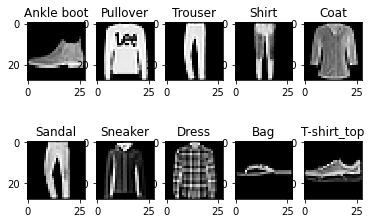

In [48]:
offset = 0
class_names_cp = np.copy(class_names)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i], cmap='gray', interpolation='none')
    class_name = class_names[y_test[i + offset]]
    while class_name not in class_names_cp:
        offset += 1
        class_name = class_names[y_test[i + offset]]
    class_names_cp = class_names_cp[class_names_cp != class_name]    
    plt.title("{}".format(class_name))

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1. 

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [33]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print(nb_classes)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)
10


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [34]:
Y_train = np_utils.to_categorical(y_train, num_classes=nb_classes)
Y_test = np_utils.to_categorical(y_test, num_classes=nb_classes)

Wielowarstwowa sieć konwolucyjna do klasyfikacji ubrań.

In [35]:
model = Sequential([
  Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                247872    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
________________________________________________

W celu skrócenia czasu uczenia sieci wskazane jest użycie GPU.

In [38]:
model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2830 - accuracy: 0.8960 - val_loss: 0.2813 - val_accuracy: 0.8953
Epoch 2/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2415 - accuracy: 0.9114 - val_loss: 0.2656 - val_accuracy: 0.9037
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2098 - accuracy: 0.9225 - val_loss: 0.2600 - val_accuracy: 0.9059
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1826 - accuracy: 0.9327 - val_loss: 0.2498 - val_accuracy: 0.9119
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1579 - accuracy: 0.9406 - val_loss: 0.2309 - val_accuracy: 0.9168
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1387 - accuracy: 0.9483 - val_loss: 0.2795 - val_accuracy: 0.9110
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1190 - accuracy: 0.9560 - val_loss: 0.2546 - val_accura

# Zapisywanie NN

Szczegółowe informacje dotyczące zapisywania modeli TensorFlow dostępne pod linkiem:

https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
export_dir = 'saved_model'
model.save(export_dir)

Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". W katalogu "saved_model" znajduje się zapisany model.

# Export do TFLite

Narzędzie `TFLiteConverter` zostanie wykorzystane do konwersji modelu NN do formatu akceptowanego przez TFLite tzn. `flat protocol buffers`.

https://www.tensorflow.org/lite/guide/get_started#2_convert_the_model_format

Wygenerowany model `"model-base.tflite"` operuje na wagach typu `float32`.

In [56]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  tflite_model = converter.convert()

  with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". 

Kolejnym krokiem jest kwantyzacja wag modelu z 32 bitowych liczb rzeczywistych do liczb 8 bitowych. Proces kwantyzacji jest uruchamiany na gotowym, wyuczonym modelu. Należy wybrać profil optymaliacji `tf.lite.Optimize.DEFAULT`.



In [60]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  converter.optimizations=[tf.lite.Optimize.DEFAULT]
  
  tflite_model = converter.convert()

  with open("model-quant.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

In [84]:
# funkcja testujaca model z wykorzystaniem interpretera TFLite
# TODO zmodyfikuj funkcje tak by zwracala (accuracy, latency)
import time

def test_model_accuracy(tflite_model):
  # Load TFLite model and allocate tensors.
  t1 = time.time()  
  interpreter = tf.lite.Interpreter(model_path=tflite_model)
  interpreter.allocate_tensors()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
    
  good_answers = 0  
  for img, label in zip(X_test, y_test):
    interpreter.set_tensor(input_index, [img])

    interpreter.invoke()

    prediction = interpreter.get_tensor(output_index)
    label_is = np.argmax(prediction, axis=-1)[0]
    label_should_be = label
    if label_is == label_should_be:
        good_answers += 1
#     print("Label is {} should be {}.".format(label_is, label_should_be))

  accuracy = good_answers / len(X_test)
  latency = time.time() - t1  
  return (accuracy, latency)


In [85]:
#TODO tylko na potrzeby testowania - do usuniecia
base = test_model_accuracy("model-base.tflite")

#TODO tylko na potrzeby testowania - do usuniecia
quant = test_model_accuracy("model-quant.tflite")


10000
10000


In [93]:
def plot(performances, x_label_name, names = ["model-base", "model-quant"]):
    y_pos = np.arange(len(names))
    fig, ax = plt.subplots()

    hbars = ax.barh(y_pos, performances, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_label_name)


    plt.show()    

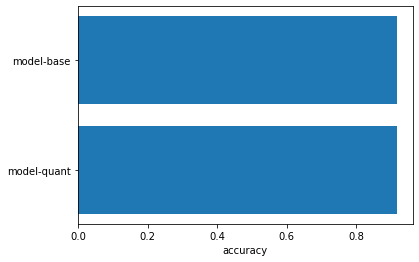

In [98]:
plot([base[0], quant[0]], "accuracy")


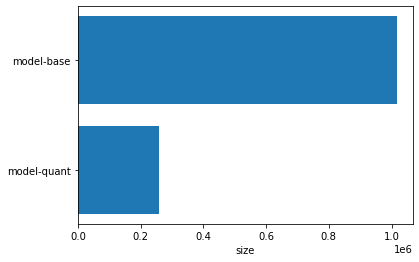

In [99]:
import os
base_size = os.path.getsize("model-base.tflite")
quant_size = os.path.getsize("model-quant.tflite")

plot([base_size, quant_size], "size")

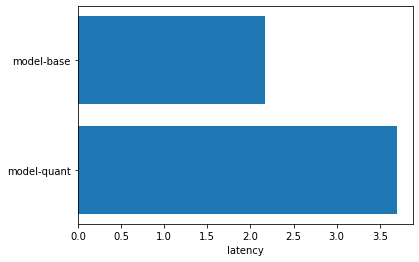

In [100]:
plot([base[1], quant[1]], "latency")

 # Wnioski
 * Skuteczność obu modeli jest na podobnym poziomie - ~91%.
 * Rozmiar "model-quant" jest niemal pięciokrotnie mniejszy niż "model-base".
 * Czas działania "model-quant" jest niemal dwukrotnie większy niż "model-base".
 
Czasy różnią się z powodu procesu kwantyzacji, który dodatkowo jest wykonywany na wyuczonym modelu w przypadku "model-quant".